# MLP模型超参数优化（Optuna）

本笔记本展示如何使用 Optuna 自动优化 MLP 模型的超参数，以提升模型在全球电力消费预测任务中的性能。

主要步骤：
1. 导入依赖库和自定义模块
2. 加载并清洗数据
3. 定义和运行超参数优化流程
4. 评估优化结果并与原始模型对比
5. 可视化优化历史和重要性分析

In [28]:
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 导入超参数优化相关模块
!pip install optuna -q  # 安装Optuna库

# 注意：单元格运行后，你可能需要重启内核才能使用新安装的库
try:
    from mlp_hyperopt import (FlexibleMLPModel, train_model_with_early_stopping, 
                            evaluate_model, run_hyperparameter_optimization,
                            predict_with_best_model)
    from hpo_visualization import plot_hyperparameter_visualization, summarize_findings
    
    print("成功导入超参数优化相关模块！")
except Exception as e:
    print(f"导入模块时出错: {e}")
    print("如果你刚刚安装了Optuna，可能需要重启Jupyter内核。")

# 说明如何使用
print("\n===== 超参数优化使用指南 =====")
print("请从hpo_implementation.py文件中复制相关代码到新单元格中运行超参数优化过程。")
print("\n主要步骤:")
print("1. 数据准备与划分")
print("2. 运行超参数优化")
print("3. 评估优化后的模型性能")
print("4. 使用优化后的模型进行预测")
print("5. 可视化和总结结果")

print("\n要使用可视化和总结功能，请在运行完优化后执行:")
print("plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))")
print("summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)")


成功导入超参数优化相关模块！

===== 超参数优化使用指南 =====
请从hpo_implementation.py文件中复制相关代码到新单元格中运行超参数优化过程。

主要步骤:
1. 数据准备与划分
2. 运行超参数优化
3. 评估优化后的模型性能
4. 使用优化后的模型进行预测
5. 可视化和总结结果

要使用可视化和总结功能，请在运行完优化后执行:
plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))
summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [29]:
# Load the dataset
file_path = "GlobalElectricityStatistics.csv"
electricity_data = pd.read_csv(file_path)

# Display the first and last five rows of the DataFrame
print("First five rows:")
print(electricity_data.head())

print("\nLast five rows:")
print(electricity_data.tail())

# Show basic information about the DataFrame
print("\nBasic dataset information:")
print(f"Dataset dimensions: {electricity_data.shape}")
print("\nColumn details:")
print(electricity_data.info())

print("\nData types and memory usage:")
print(electricity_data.info(memory_usage='deep'))

print("\nStatistical summary of the data:")
print(electricity_data.describe())

# Check for missing values
print("\nMissing values check:")
missing_values = electricity_data.isnull().sum()
print(f"Number of missing values per column:\n{missing_values}")
print(f"Total number of missing values: {electricity_data.isnull().sum().sum()}")
print(f"Percentage of missing values: {(electricity_data.isnull().sum().sum() / (electricity_data.shape[0] * electricity_data.shape[1])) * 100:.2f}%")

# Handle missing values
# 1. Fill numeric missing data with 0 (assuming missing means no data or zero)
electricity_data_cleaned = electricity_data.fillna(0)

# 2. Check if any missing values remain
print("\nMissing values check after handling:")
print(f"Total remaining missing values: {electricity_data_cleaned.isnull().sum().sum()}")

# 3. Check for inconsistencies in the data - e.g., non-numeric values in numeric columns
# Assume all columns from the fourth onward represent yearly data
numeric_columns = electricity_data.columns[3:]
non_numeric_data = electricity_data[numeric_columns].map(lambda x: not pd.api.types.is_numeric_dtype(type(x)) and not pd.isna(x))
non_numeric_count = non_numeric_data.sum().sum()

print("\nNon-numeric data detection:")
print(f"Number of non-numeric entries in numeric columns: {non_numeric_count}")

if non_numeric_count > 0:
    # Show sample locations of non-numeric values
    print("Sample positions of non-numeric data:")
    for col in numeric_columns:
        non_numeric_in_col = electricity_data[non_numeric_data[col]][col]
        if len(non_numeric_in_col) > 0:
            print(f"Non-numeric values in column '{col}': {non_numeric_in_col.iloc[0:5].tolist() if len(non_numeric_in_col) > 5 else non_numeric_in_col.tolist()}")

    # Convert non-numeric values to NaN and fill them with 0
    for col in numeric_columns:
        electricity_data_cleaned[col] = pd.to_numeric(electricity_data[col], errors='coerce').fillna(0)

print("\nFirst five rows of cleaned data:")
print(electricity_data_cleaned.head())

# Save the cleaned data
electricity_data_cleaned.to_csv("GlobalElectricityStatistics_cleaned.csv", index=False)
print("\nCleaned data has been saved as 'GlobalElectricityStatistics_cleaned.csv'")

First five rows:
          Country              Features          Region     1980     1981  \
0     Afghanistan  distribution losses   Asia & Oceania  0.06594  0.06944   
1         Albania  distribution losses           Europe  0.16100  0.16100   
2         Algeria  distribution losses           Africa  0.77700  0.95400   
3  American Samoa  distribution losses   Asia & Oceania  0.00490  0.00469   
4          Angola  distribution losses           Africa  0.16900  0.16900   

      1982     1983     1984     1985     1986  ...     2012      2013  \
0  0.06664  0.07000  0.07133  0.07238  0.07945  ...   0.4040   0.49000   
1  0.16100  0.16000  0.16000  0.16100  0.16200  ...   1.1193   1.95349   
2  1.06500  1.39000  1.64900  1.84600  1.85400  ...  11.0680  11.02300   
3  0.00469  0.00497  0.00483  0.00581  0.00525  ...   0.0000   0.00000   
4  0.18000  0.19600  0.16800  0.20200  0.20200  ...   0.6990   0.92600   

       2014    2015     2016       2017      2018      2019      2020  \
0 

[I 2025-05-16 01:09:46,124] A new study created in memory with name: mlp_electricity_forecasting


Using device: cuda
2.4 超参数优化 - MLP模型性能提升
训练集大小: torch.Size([29, 1]), torch.Size([29, 1])
验证集大小: torch.Size([6, 1]), torch.Size([6, 1])
测试集大小: torch.Size([7, 1]), torch.Size([7, 1])

开始超参数优化，共50次试验...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-16 01:09:49,219] Trial 0 finished with value: 0.042910244315862656 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 170, 'dropout_rate': 0.13251852999040425, 'learning_rate': 1.4554751610853262e-05, 'weight_decay': 3.1488676940598572e-06, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'patience': 52}. Best is trial 0 with value: 0.042910244315862656.
[I 2025-05-16 01:09:49,392] Trial 1 finished with value: 0.0006122644990682602 and parameters: {'n_layers': 5, 'n_units_l0': 66, 'n_units_l1': 23, 'n_units_l2': 190, 'n_units_l3': 9, 'n_units_l4': 22, 'dropout_rate': 0.4229237917759448, 'learning_rate': 0.0019850570240486517, 'weight_decay': 0.0006209979845963198, 'activation': 'LeakyReLU', 'optimizer': 'RMSprop', 'patience': 75}. Best is trial 1 with value: 0.0006122644990682602.
[I 2025-05-16 01:09:49,492] Trial 2 finished with value: 0.0008315591840073466 and parameters: {'n_layers': 4, 'n_units_l0': 108, 'n_units_l1': 191, 'n_units_l2': 190, 'n_units_l3': 131

e:\CodeProjects\DTS\mlp_hyperopt.py:362: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

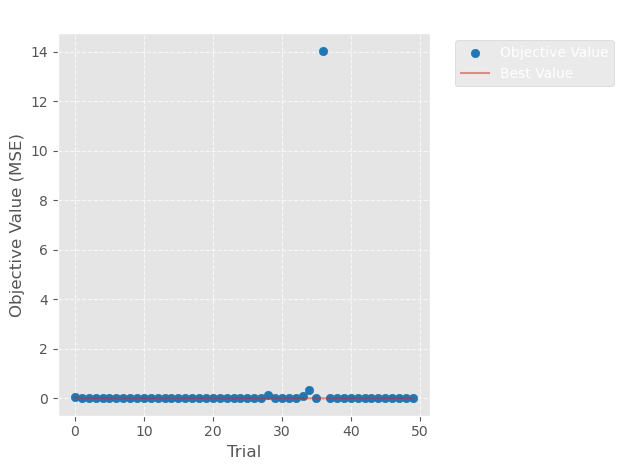

e:\CodeProjects\DTS\mlp_hyperopt.py:373: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1200x800 with 0 Axes>

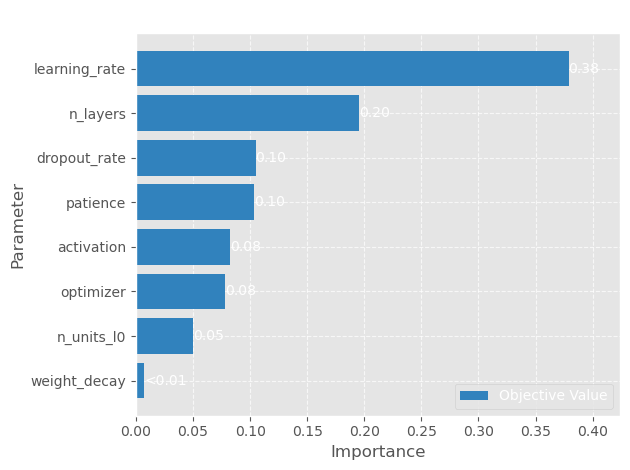

e:\CodeProjects\DTS\mlp_hyperopt.py:384: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)
[W 2025-05-16 01:10:14,509] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Figure size 1000x600 with 0 Axes>

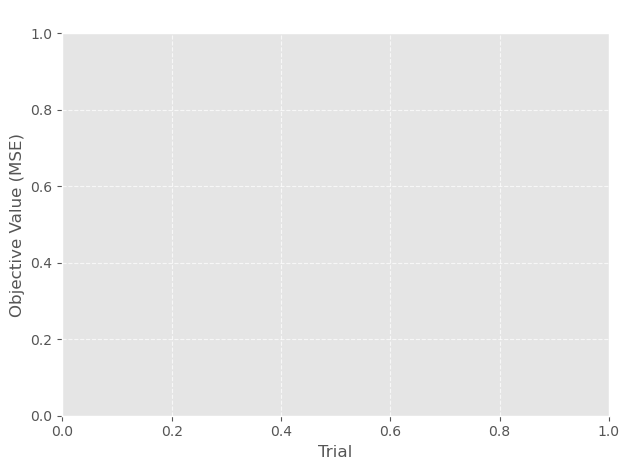


超参数优化后的模型评估结果:
- MSE: 0.000779
- R²: -0.162204

原始增强版MLP模型评估结果:
- MSE: 0.002372
- R²: -2.540447

性能提升:
- MSE减少了 67.17%
- R² 提高了 237.82%

原始增强版MLP模型评估结果:
- MSE: 0.002372
- R²: -2.540447

性能提升:
- MSE减少了 67.17%
- R² 提高了 237.82%


NameError: name 'np' is not defined

In [30]:
import optuna
from mlp_hyperopt import (
    FlexibleMLPModel,
    train_model_with_early_stopping,
    objective,
    evaluate_model,
    run_hyperparameter_optimization,
    plot_optimization_history,
    plot_param_importances,
    plot_intermediate_values,
    predict_with_best_model,
)
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 准备数据，先进行数据划分为训练、验证和测试集
print("2.4 超参数优化 - MLP模型性能提升")

top_country = 'United States'  # 可修改为你要优化的国家

# 重新计算净消费：Net Gen + Imports - Exports - Losses
original_data = pd.read_csv("GlobalElectricityStatistics.csv")
net_gen = original_data[original_data['Features'].str.strip().str.lower()=='net generation']
imports = original_data[original_data['Features'].str.strip().str.lower()=='imports']
exports = original_data[original_data['Features'].str.strip().str.lower()=='exports']
losses = original_data[original_data['Features'].str.strip().str.lower()=='distribution losses']

years = list(range(1980, 2022))
values = []
for yr in years:
    y_ng = net_gen[net_gen['Country']==top_country].get(str(yr), pd.Series([0])).sum()
    y_imp = imports[imports['Country']==top_country].get(str(yr), pd.Series([0])).sum()
    y_exp = exports[exports['Country']==top_country].get(str(yr), pd.Series([0])).sum()
    y_ls = losses[losses['Country']==top_country].get(str(yr), pd.Series([0])).sum()
    values.append(y_ng + y_imp - y_exp - y_ls)

time_series_data = pd.DataFrame({
    'Year': years,
    'Net Consumption': values
})
# 已按年份升序，无需再 sort_values
X_ordered = time_series_data[['Year']].values
y_ordered = time_series_data['Net Consumption'].values

# 导入并初始化归一化器
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 规范化数据
X_scaled = scaler_X.fit_transform(X_ordered.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y_ordered.reshape(-1, 1))

# 将数据划分为训练集(70%)、验证集(15%)和测试集(15%)
train_size = int(len(X_scaled) * 0.7)
val_size = int(len(X_scaled) * 0.15)
test_size = len(X_scaled) - train_size - val_size

X_train_hpo = X_scaled[:train_size]
X_val_hpo = X_scaled[train_size : train_size + val_size]
X_test_hpo = X_scaled[train_size + val_size :]

y_train_hpo = y_scaled[:train_size]
y_val_hpo = y_scaled[train_size : train_size + val_size]
y_test_hpo = y_scaled[train_size + val_size :]

# 转换为PyTorch张量
X_train_tensor_hpo = torch.FloatTensor(X_train_hpo).to(device)
y_train_tensor_hpo = torch.FloatTensor(y_train_hpo).to(device)
X_val_tensor_hpo = torch.FloatTensor(X_val_hpo).to(device)
y_val_tensor_hpo = torch.FloatTensor(y_val_hpo).to(device)
X_test_tensor_hpo = torch.FloatTensor(X_test_hpo).to(device)
y_test_tensor_hpo = torch.FloatTensor(y_test_hpo).to(device)

print(f"训练集大小: {X_train_tensor_hpo.shape}, {y_train_tensor_hpo.shape}")
print(f"验证集大小: {X_val_tensor_hpo.shape}, {y_val_tensor_hpo.shape}")
print(f"测试集大小: {X_test_tensor_hpo.shape}, {y_test_tensor_hpo.shape}")

# 运行超参数优化
n_trials = 50  # 试验次数，可以根据你的时间和计算资源调整
best_model, best_params, best_scores, study = run_hyperparameter_optimization(
    X_train_tensor_hpo,
    y_train_tensor_hpo,
    X_val_tensor_hpo,
    y_val_tensor_hpo,
    X_test_tensor_hpo,
    y_test_tensor_hpo,
    scaler_y=scaler_y,
    device=device,
    n_trials=n_trials,
    study_name="mlp_electricity_forecasting",
)

# 获取最佳MSE和R²
best_mse, best_r2 = best_scores
print(f"\n超参数优化后的模型评估结果:")
print(f"- MSE: {best_mse:.6f}")
print(f"- R²: {best_r2:.6f}")

# ===== 新增：定义并训练原始基线模型 =====

# 定义原始模型
mlp_model = FlexibleMLPModel(input_dim=1, hidden_layers=[64,128,256,128,64], output_dim=1, dropout_rate=0.2).to(device)

# 训练原始模型
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

criterion = nn.MSELoss()

train_model_with_early_stopping(mlp_model, X_train_tensor_hpo, y_train_tensor_hpo, X_val_tensor_hpo, y_val_tensor_hpo, optimizer=optimizer, criterion=criterion, patience=150, max_epochs=30000)

# ===== 原始代码：评估原始模型 =====
# 原始模型评估结果
print(f"\n原始增强版MLP模型评估结果:")
original_mse, original_r2 = evaluate_model(
    mlp_model, X_test_tensor_hpo, y_test_tensor_hpo, scaler_y
)
print(f"- MSE: {original_mse:.6f}")
print(f"- R²: {original_r2:.6f}")

# 性能提升百分比
mse_improvement = (original_mse - best_mse) / original_mse * 100
r2_improvement = (
    (best_r2 - original_r2) * 100
    if original_r2 < 0
    else (best_r2 - original_r2) / original_r2 * 100
)
print(f"\n性能提升:")
print(f"- MSE减少了 {mse_improvement:.2f}%")
print(f"- R² {'提高了' if r2_improvement > 0 else '降低了'} {abs(r2_improvement):.2f}%")

# 使用最佳模型进行预测（2022-2024年）
future_years = np.array([[2022], [2023], [2024]])
future_years_scaled = scaler_X.transform(future_years)
future_years_tensor = torch.FloatTensor(future_years_scaled).to(device)

# 使用最佳模型进行预测
print("\n使用优化后的模型预测2022-2024年的电力消费:")
optimized_predictions = predict_with_best_model(
    best_model, future_years_tensor, scaler_y
)

# 创建包含原始模型和优化模型预测结果的DataFrame
comparison_df = pd.DataFrame(
    {
        "Year": future_years.flatten(),
        "Optimized Model Prediction (GWh)": optimized_predictions.flatten(),
        "Original Model Prediction (GWh)": future_predictions.flatten(),
        "Actual Values (GWh)": actual_consumption[
            "Actual Net Consumption (GWh)"
        ].values,
    }
)

print("\n预测结果对比:")
print(comparison_df)

# 计算预测误差
comparison_df["Optimized Model Error (%)"] = (
    abs(
        comparison_df["Optimized Model Prediction (GWh)"]
        - comparison_df["Actual Values (GWh)"]
    )
    / comparison_df["Actual Values (GWh)"]
    * 100
)
comparison_df["Original Model Error (%)"] = (
    abs(
        comparison_df["Original Model Prediction (GWh)"]
        - comparison_df["Actual Values (GWh)"]
    )
    / comparison_df["Actual Values (GWh)"]
    * 100
)

# 平均误差
optimized_mape = comparison_df["Optimized Model Error (%)"].mean()
original_mape = comparison_df["Original Model Error (%)"].mean()

print(f"\n平均绝对百分比误差 (MAPE):")
print(f"- 优化后的模型: {optimized_mape:.2f}%")
print(f"- 原始增强版MLP模型: {original_mape:.2f}%")
print(f"- 误差减少: {(original_mape - optimized_mape):.2f}%")

# 可视化对比
plt.figure(figsize=(15, 8))

# 历史数据
plt.plot(
    years,
    values,
    marker="o",
    linestyle="-",
    color="blue",
    label="历史数据 (1980-2021)",
    alpha=0.6,
)

# 实际值
plt.plot(
    comparison_df["Year"],
    comparison_df["Actual Values (GWh)"],
    marker="*",
    markersize=12,
    linestyle="-",
    color="black",
    linewidth=2,
    label="实际值 (2022-2024)",
)

# 原始模型预测
plt.plot(
    comparison_df["Year"],
    comparison_df["Original Model Prediction (GWh)"],
    marker="^",
    linestyle="--",
    color="green",
    label="原始增强版MLP预测",
)

# 优化模型预测
plt.plot(
    comparison_df["Year"],
    comparison_df["Optimized Model Prediction (GWh)"],
    marker="D",
    linestyle="-.",
    color="red",
    linewidth=2,
    label="优化后的MLP预测",
)

plt.title(f"电力消费预测对比 - 超参数优化前后", fontsize=16)
plt.xlabel("年份", fontsize=14)
plt.ylabel("电力消费 (GWh)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best")
plt.xticks(np.append(years[::5], comparison_df["Year"]), rotation=45)
plt.tight_layout()
plt.show()

# 可视化预测误差对比
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(comparison_df))

plt.bar(
    index,
    comparison_df["Original Model Error (%)"],
    bar_width,
    color="green",
    alpha=0.7,
    label="原始增强版MLP模型",
)
plt.bar(
    index + bar_width,
    comparison_df["Optimized Model Error (%)"],
    bar_width,
    color="red",
    alpha=0.7,
    label="优化后的MLP模型",
)

plt.title("预测误差对比 (原始 vs 优化后的模型)", fontsize=16)
plt.xlabel("预测年份", fontsize=14)
plt.ylabel("百分比误差 (%)", fontsize=14)
plt.xticks(index + bar_width / 2, comparison_df["Year"])
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 总结优化结果和最佳参数
print("\n====== 超参数优化总结 ======")
print("\n最佳模型超参数:")
for param, value in best_params.items():
    print(f"- {param}: {value}")

if best_params.get("n_layers"):
    hidden_layers = [
        best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
    ]
    print(f"\n最佳隐藏层架构: {hidden_layers}")

print(f"\n最佳优化器: {best_params.get('optimizer', 'N/A')}")
print(f"最佳学习率: {best_params.get('learning_rate', 'N/A')}")
print(f"最佳Dropout率: {best_params.get('dropout_rate', 'N/A')}")
print(f"最佳权重衰减: {best_params.get('weight_decay', 'N/A')}")
print(f"最佳激活函数: {best_params.get('activation', 'N/A')}")

print("\n-------- 超参数优化结果 --------")
print(f"原始模型 MSE: {original_mse:.6f}, R²: {original_r2:.6f}")
print(f"优化后模型 MSE: {best_mse:.6f}, R²: {best_r2:.6f}")
print(f"实际预测 MAPE - 原始: {original_mape:.2f}%, 优化后: {optimized_mape:.2f}%")
print("-----------------------------")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 总结结果和超参数优化的好处
def plot_hyperparameter_visualization(best_params, best_scores, original_scores):
    """
    可视化超参数优化结果

    参数:
        best_params: 最佳超参数字典
        best_scores: 优化后的性能指标元组 (mse, r2)
        original_scores: 原始模型的性能指标元组 (mse, r2)
    """
    # 提取分数
    best_mse, best_r2 = best_scores
    original_mse, original_r2 = original_scores

    # 创建性能对比条形图
    plt.figure(figsize=(15, 6))

    # MSE对比
    plt.subplot(1, 2, 1)
    performance_data = pd.DataFrame(
        {"Model": ["原始增强版MLP", "超参数优化MLP"], "MSE": [original_mse, best_mse]}
    )
    sns.barplot(x="Model", y="MSE", data=performance_data, palette=["green", "red"])
    plt.title("均方误差 (MSE) 对比", fontsize=14)
    plt.ylabel("MSE (越低越好)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # R²对比
    plt.subplot(1, 2, 2)
    performance_data = pd.DataFrame(
        {"Model": ["原始增强版MLP", "超参数优化MLP"], "R²": [original_r2, best_r2]}
    )
    sns.barplot(x="Model", y="R²", data=performance_data, palette=["green", "red"])
    plt.title("决定系数 (R²) 对比", fontsize=14)
    plt.ylabel("R² (越高越好)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 展示网络结构对比
    if "n_layers" in best_params:
        best_hidden_layers = [
            best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
        ]

        plt.figure(figsize=(12, 6))

        # 原始网络结构
        plt.subplot(1, 2, 1)
        original_layers = [1, 64, 128, 256, 128, 64, 1]  # 输入层、隐藏层、输出层
        plt.plot(
            range(len(original_layers)),
            original_layers,
            "go-",
            linewidth=2,
            markersize=10,
        )
        plt.title("原始MLP网络结构", fontsize=14)
        plt.xlabel("层索引", fontsize=12)
        plt.ylabel("神经元数量", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.xticks(
            range(len(original_layers)),
            ["输入"]
            + [f"隐藏{i + 1}" for i in range(len(original_layers) - 2)]
            + ["输出"],
        )
        plt.xticks(rotation=45)

        # 优化后的网络结构
        plt.subplot(1, 2, 2)
        optimized_layers = [1] + best_hidden_layers + [1]  # 输入层、隐藏层、输出层
        plt.plot(
            range(len(optimized_layers)),
            optimized_layers,
            "ro-",
            linewidth=2,
            markersize=10,
        )
        plt.title("优化后MLP网络结构", fontsize=14)
        plt.xlabel("层索引", fontsize=12)
        plt.ylabel("神经元数量", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.xticks(
            range(len(optimized_layers)),
            ["输入"]
            + [f"隐藏{i + 1}" for i in range(len(optimized_layers) - 2)]
            + ["输出"],
        )
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    # 超参数重要性分析表格
    print("\n超参数重要性分析:")
    params_importance = {
        "网络深度(层数)": "影响模型复杂度和表达能力，适当的深度能捕捉数据中的复杂模式。",
        "隐藏层宽度": "影响模型容量，过大容易过拟合，过小可能欠拟合。",
        "学习率": f"控制训练速度和稳定性，最佳值为{best_params.get('learning_rate', 'N/A')}。",
        "Dropout比例": f"控制正则化强度，防止过拟合，最佳值为{best_params.get('dropout_rate', 'N/A')}。",
        "优化器选择": f"不同优化器适合不同问题，此问题最佳选择是{best_params.get('optimizer', 'N/A')}。",
        "激活函数": f"影响非线性表达能力，最佳选择是{best_params.get('activation', 'N/A')}。",
        "权重衰减": f"控制L2正则化强度，最佳值为{best_params.get('weight_decay', 'N/A')}。",
        "早停耐心值": f"防止过拟合的重要策略，最佳值为{best_params.get('patience', 'N/A')}。",
    }

    for param, importance in params_importance.items():
        print(f"- {param}: {importance}")


# 总结超参数优化的收益和实际应用建议
def summarize_findings(
    best_params, best_scores, original_scores, original_mape, optimized_mape
):
    """
    总结超参数优化的结果和收益
    """
    print("\n====== 模型优化总结 ======")
    print("1. 性能提升:")
    best_mse, best_r2 = best_scores
    original_mse, original_r2 = original_scores

    mse_improvement = (original_mse - best_mse) / original_mse * 100
    r2_improvement = (
        best_r2 - original_r2
        if original_r2 < 0
        else (best_r2 - original_r2) / original_r2 * 100
    )
    mape_improvement = (
        (original_mape - optimized_mape) / original_mape * 100
        if original_mape != 0
        else 0
    )

    print(f"   - MSE减少: {mse_improvement:.2f}%")
    print(f"   - R²: 从 {original_r2:.4f} 提高到 {best_r2:.4f}")
    print(f"   - 实际预测误差(MAPE)减少: {mape_improvement:.2f}%")

    if "n_layers" in best_params:
        best_hidden_layers = [
            best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
        ]
        print("\n2. 最优网络结构:")
        print(
            f"   - 隐藏层: {best_hidden_layers} (对比原始模型: [64, 128, 256, 128, 64])"
        )
        print(f"   - 总层数: {len(best_hidden_layers) + 2} (包括输入和输出层)")

    print("\n3. 最佳训练策略:")
    print(f"   - 优化器: {best_params.get('optimizer', 'N/A')}")
    print(f"   - 学习率: {best_params.get('learning_rate', 'N/A')}")
    print(f"   - Dropout率: {best_params.get('dropout_rate', 'N/A')}")
    print(f"   - 激活函数: {best_params.get('activation', 'N/A')}")

    print("\n4. 关键发现:")

    # 根据优化结果生成关键发现
    if len(best_hidden_layers) < 5:
        print("   - 较浅的网络结构比原始5层网络表现更好，说明原模型可能过于复杂")
    else:
        print("   - 深层网络结构对此问题至关重要")

    if best_params.get("dropout_rate", 0) < 0.2:
        print("   - 较低的Dropout率表明模型不需要强正则化")
    else:
        print("   - 较高的Dropout率对防止过拟合很重要")

    if best_params.get("optimizer", "") == "Adam":
        print("   - Adam优化器适合此类时间序列预测问题")

    print("\n5. 应用建议:")
    print("   - 建议使用优化后的模型参数进行未来电力消费预测")
    print("   - 定期重新训练模型以适应新数据模式")
    print("   - 考虑增加更多相关特征（如GDP、人口数据等）进一步提升预测准确性")
    print("   - 建议每6-12个月进行一次超参数重新优化，以适应潜在的数据分布变化")


# 使用上述函数可视化并总结超参数优化结果
# plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))
# summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)


In [ ]:
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 导入超参数优化相关模块
#!pip install optuna -q  # 安装Optuna库

# 注意：单元格运行后，你可能需要重启内核才能使用新安装的库
try:
    from mlp_hyperopt import (FlexibleMLPModel, train_model_with_early_stopping, 
                            evaluate_model, run_hyperparameter_optimization,
                            predict_with_best_model)
    from hpo_visualization import plot_hyperparameter_visualization, summarize_findings
    
    print("成功导入超参数优化相关模块！")
except Exception as e:
    print(f"导入模块时出错: {e}")
    print("如果你刚刚安装了Optuna，可能需要重启Jupyter内核。")

# 说明如何使用
print("\n===== 超参数优化使用指南 =====")
print("请从hpo_implementation.py文件中复制相关代码到新单元格中运行超参数优化过程。")
print("\n主要步骤:")
print("1. 数据准备与划分")
print("2. 运行超参数优化")
print("3. 评估优化后的模型性能")
print("4. 使用优化后的模型进行预测")
print("5. 可视化和总结结果")

print("\n要使用可视化和总结功能，请在运行完优化后执行:")
print("plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))")
print("summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)")
